In [8]:
import numpy as np
import networkx as nx
import math
import random
#from sklearn.cluster import KMeans
from typing import List
import matplotlib
import colorsys
from VRP import VRP 
from numbaVRP import *
from ORToolsVRP import get_ORTools_result
#%load_ext line_profiler


Example of chromosome: [ 5 18  4 10 16  6  1  7  0  8  9  3 13 14 19 17 15 11  2 12]
Example of routes: [['B', 5, 18, 4, 10, 16, 6, 1, 7, 'B'], ['B', 0, 8, 9, 3, 13, 'B'], ['B', 14, 19, 17, 15, 'B'], ['B', 11, 2, 12, 'B']]
Example total distance of routes: 2434.028124712319


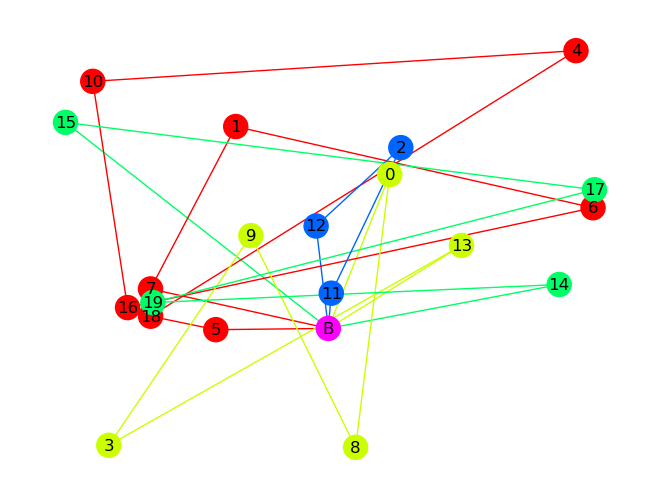

In [26]:
seed = 30 # FIX A SEED TO GET DETERMINISTIC RESULT
np.random.seed(seed) 
random.seed(seed)

n_clients = 20 # number of clients to serve
vrp = VRP(200,200,n_clients,20)
vrp.init_random_population() #initialize first generation
print("Example of chromosome:",vrp.population[0])
distance,routes = vrp.fitness_function(0)
print("Example of routes:",routes)
print("Example total distance of routes:",distance)

vrp.draw_chromosome_paths()#draw chromosome routes with networkx
chs = list()#clients
fs = list()#fitnesses

1084.6408647651022


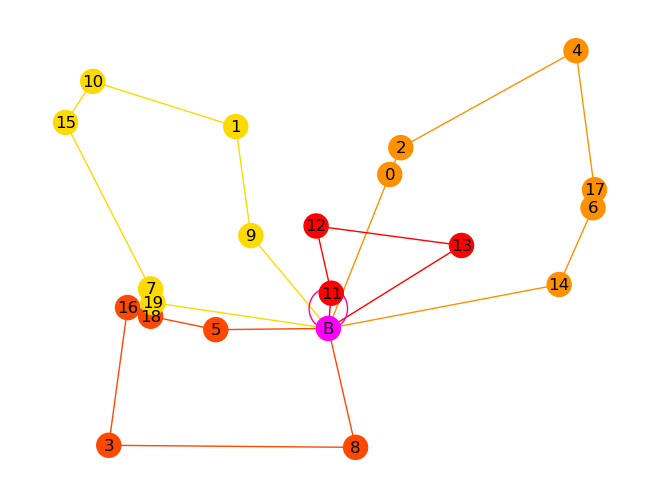

In [27]:
optimal_fitness = get_ORTools_result(vrp)#use the ORTools solver to get best guided local search solution
print(optimal_fitness)

In [29]:
total_epochs = 500 #number of total epochs 
iterations_per_epoch = 2000
epochs_before_restart = 2
decimation = 4 # keep 1/decimation percent of the population
mut = 0.15 #mutation probability

In [30]:
edge_weights_py = nx.get_edge_attributes(vrp.graph,'weight')
# now we convert the problem to numpy and numba in order to make it run faster
edge_weights_numba = Dict.empty(
        key_type=types.UniTuple(types.int64, 2), 
        value_type=types.float_
    )
for (k1,k2),v in edge_weights_py.items():
    edge_weights_numba[(k1,k2)]=v
    edge_weights_numba[(k2,k1)]=v

tries=0
previous_f = -1
equal_fitness_counter = 0 
# Running genetic algorithm with warm restarts if the best fitness is not improving
try:
    while tries < total_epochs:
        print(tries)
        if equal_fitness_counter >= epochs_before_restart:#*((multiplier_restart if min(fs) == f else 1) if fs else 1):
            old_best = vrp.population[0].copy()#
            vrp.init_random_population(False)
            vrp.population[0] = old_best#
            equal_fitness_counter = 0
            print("Restarting...\n")
        ch, f,pop = numba_run(vrp.population,vrp.capacities,edge_weights_numba,vrp.truck_capacity,vrp.n_clients,
                              n_iterations=iterations_per_epoch,decimation_factor=decimation,mutation_p=mut)
        chs.append(ch)
        fs.append(f)
        
        f, routes = vrp.fitness_function(0)
        new_routes= []
        for route in routes:
            for i in range(len(route)):
                if route[i] == 'B':
                    route[i] = -1 
            tsp_solution = nx.approximation.traveling_salesman_problem(vrp.graph,nodes = route)
            tsp_solution=tsp_solution[1:-1]
            new_routes= new_routes +tsp_solution
        vrp.population[0] = new_routes
        print(f,end=',',flush=True)
        tries+=1
        if previous_f == f:
            equal_fitness_counter +=1
        else:
            equal_fitness_counter = 0
        previous_f  = f
except KeyboardInterrupt:
    pass

0
1243.9149667327465,1
1243.9149667327465,2
1188.527343184469,3
1188.527343184469,4
1188.527343184469,5
Restarting...

1182.8024487237008,6
1182.8024487237008,7
1182.8024487237008,8
Restarting...

1220.5961688338803,9
1220.5961688338803,10
1220.5961688338803,11
Restarting...

1264.192428679727,12
1264.192428679727,13
1264.192428679727,14
Restarting...

1277.144514873689,15
1133.14655043066,16
1133.14655043066,17
1133.14655043066,18
Restarting...

1134.1273037038063,19
1134.1273037038063,20
1134.1273037038063,21
Restarting...

1174.3653418646347,22
1174.3653418646347,23
1174.3653418646347,24
Restarting...

1232.6004094009033,25
1232.6004094009033,26
1232.6004094009033,27
Restarting...

1255.2344036774784,28
1176.463650943176,29
1176.463650943176,30
1176.463650943176,31
Restarting...

1133.889388028708,32
1133.889388028708,33
1133.889388028708,34
Restarting...

1241.7264988845704,35
1241.7264988845704,36
1241.7264988845704,37
Restarting...

1214.2722624488904,38
1214.2722624488904,39
121

SystemError: CPUDispatcher(<function numba_run at 0x11790b740>) returned a result with an exception set

1073.584228515625


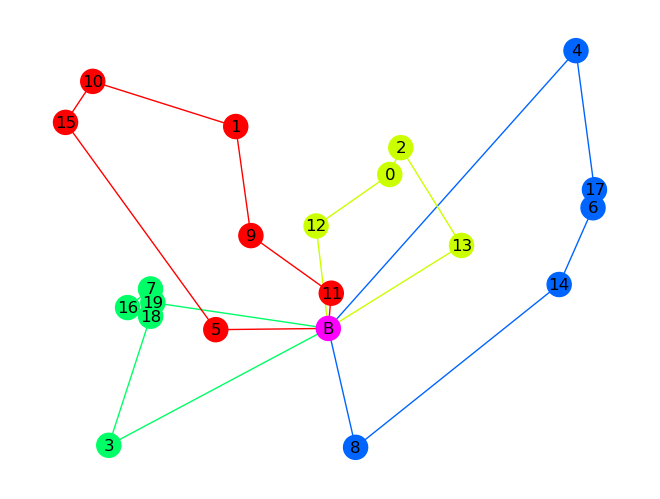

In [31]:
import matplotlib.pyplot as plt
print(min(fs))
#print(fs[100])
vrp.population[0] = chs[fs.index(min(fs))]
vrp.draw_chromosome_paths(0)
#plt.savefig("GAsolution_15cities.png")

Text(0.5, 1.0, 'Total route distance')

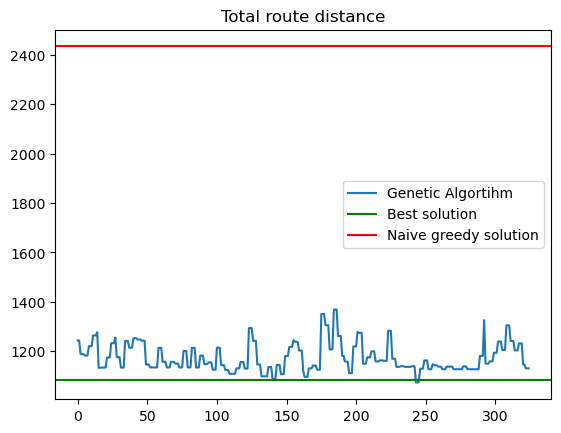

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(len(fs)),(fs[:]),label="Genetic Algortihm")
plt.axhline(optimal_fitness,color='g',label="Best solution")
plt.axhline(distance,color='r',label="Naive greedy solution")

#plt.axvline(1000,color='black')
#plt.axvline(2000,color='black')
#plt.axvline(3000,color='black')
plt.legend()
plt.title("Total route distance")
#plt.savefig(f"seed{seed}nodes{n_clients}mut{mut}iter{iterations_per_epoch}decim{decimation}restart{epochs_before_restart}.png")
#len(fs)=100

In [43]:
print("Best route length found by GA:",min(fs),"km")
print("Best route length found by ORTools Solver:",optimal_fitness,"km")
if optimal_fitness < min(fs):
    print("In this instance the ORTools is better")
else:
    print(f"In this instance the genetic algorithm is better by {abs(optimal_fitness-min(fs))} km")    

Best route length found by GA: 1073.584228515625 km
Best route length found by ORTools Solver: 1084.6408647651022 km
In this instance the genetic algorithm is better by 11.056636249477151 km


Text(0.5, 1.0, 'Distribution of route lengths in all epochs (less is better)')

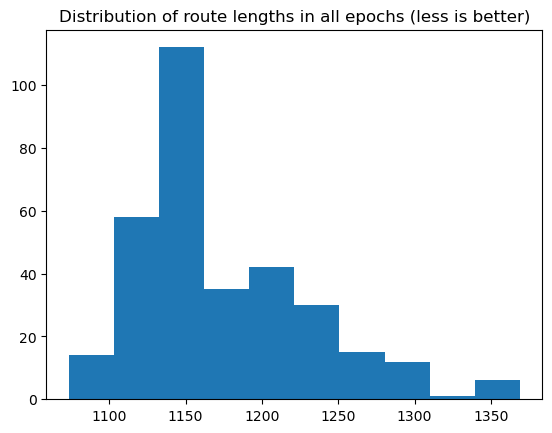

In [44]:
len(np.unique(vrp.population,axis=1))
hh = plt.hist(fs)
plt.title("Distribution of route lengths in all epochs (less is better)")